In [3]:
import pennylane as qml


In [134]:
H = qml.Hamiltonian(
    [1, 1, 0.5],
    [qml.PauliX(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)]
)
print(H)

(1) [X0]
+ (1) [Z1]
+ (0.5) [X0 X1]


In [135]:
dev = qml.device('default.qubit', wires=2)

t = 1
n = 1

@qml.qnode(dev)
def circuit():
    qml.templates.ApproxTimeEvolution(H, t, n)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

circuit()
print(circuit.draw())

 0: ──H──────RZ(2)──H──H──╭RZ(1)──H──┤ ⟨Z⟩ 
 1: ──RZ(2)──H────────────╰RZ(1)──H──┤ ⟨Z⟩ 



In [136]:
def circ(theta):
    qml.RX(theta, wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0, 1])

    
@qml.qnode(dev)
def circuit(params, **kwargs):
    qml.layer(circ, 3, params)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

circuit([0.3, 0.4, 0.5])
print(circuit.draw())

 0: ──RX(0.3)──╭C──RX(0.4)──╭C──RX(0.5)──╭C──┤ ⟨Z⟩ 
 1: ──H────────╰X──H────────╰X──H────────╰X──┤ ⟨Z⟩ 



In [138]:
dev = qml.device('default.qubit', wires=1)


def circ(theta):
    qml.RX(theta, wires=0)


    
@qml.qnode(dev)
def circuit(params, **kwargs):
    qml.layer(circ, 1, params)
    return [qml.expval(qml.PauliZ(i)) for i in range(1)]

circuit([0.3])
print(circuit.draw())

 0: ──RX(0.3)──┤ ⟨Z⟩ 



In [146]:
dev = qml.device('default.qubit', wires=1)

t = 1
n = 1


H = qml.Hamiltonian(
    [2],
    [qml.PauliX(0)]
)

@qml.qnode(dev)
def circuit():
    qml.templates.ApproxTimeEvolution(H, t, n)
    return [qml.expval(qml.PauliZ(i)) for i in range(1)]

circuit()
print(circuit.draw())

 0: ──H──RZ(4)──H──┤ ⟨Z⟩ 



# Minimum vertex cover

In [14]:
from pennylane import qaoa
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

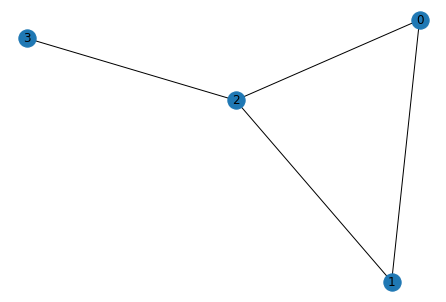

In [15]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

In [19]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

In [21]:
print(cost_h)

(0.75) [Z0 Z1]
+ (0.5) [Z0]
+ (0.5) [Z1]
+ (0.75) [Z0 Z2]
+ (1.25) [Z2]
+ (0.75) [Z1 Z2]
+ (0.75) [Z2 Z3]
+ (-0.25) [Z3]


In [22]:
print(mixer_h)

(1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


In [56]:
def qaoa_layer(gamma, alpha):
    n = 1
    qml.templates.ApproxTimeEvolution(cost_h, gamma, n)
    qml.templates.ApproxTimeEvolution(mixer_h, alpha, n)

In [97]:
wires = range(4)
depth = 3

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [98]:
dev = qml.device("default.qubit", wires=wires)
cost_function = qml.ExpvalCost(circuit, cost_h, dev)


In [99]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = [[0.5]*depth, [0.5]*depth]

In [100]:
for i in range(steps):
    params = optimizer.step(cost_function, params)
    print(cost_function(params))
print("Optimal Parameters")
print(params)


-0.06619825569349881
-0.42485205265987713
-0.5864863372574624
-0.6800218286201392
-0.7440000588537361
-0.7935892512759266
-0.8354247455155223
-0.8727281496705954
-0.9072836084672463
-0.9402003345666969
-0.9722070931962047
-1.003772357459853
-1.0351626472223996
-1.066480308026116
-1.0976950553607747
-1.1286740087844893
-1.1592116010808833
-1.18905933953514
-1.2179544850404846
-1.2456460555938242
-1.2719162952107945
-1.2965960100538987
-1.319572916442141
-1.3407931425127158
-1.3602569664250417
-1.378010500892239
-1.3941352320026255
-1.4087371308569
-1.4219366216948761
-1.4338601759891842
-1.444633838823736
-1.4543786518105815
-1.4632077307632714
-1.471224666029273
-1.4785229041369425
-1.485185806958227
-1.491287142291973
-1.4968918203100674
-1.5020567443187474
-1.5068316880093982
-1.5112601444009568
-1.5153801152796302
-1.5192248259926653
-1.5228233608324049
-1.5262012205755113
-1.5293808072984243
-1.5323818433241434
-1.5352217317423253
-1.5379158658474574
-1.540477894364478
-1.542919948

In [109]:
cost_function(params)

-1.5760843637219817

In [113]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

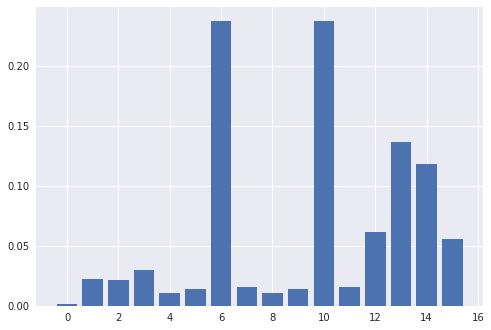

In [114]:
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.show()